In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
import time

# Preprocessing, modelling and evaluating
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.metrics import classification_report


In [18]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / (1024 ** 2) 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / (1024 ** 2)
    print(f"start_mem Memory usage of df_train: {start_mem:.2f} MB")
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [19]:
df_trans = pd.read_csv('../input/train_transaction.csv')
#df_test_trans = pd.read_csv('../input/test_transaction.csv')

df_id = pd.read_csv('../input/train_identity.csv')
#df_test_id = pd.read_csv('../input/test_identity.csv')

sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

df_train = df_trans.merge(df_id, how='left', on='TransactionID')
#df_test = df_test_trans.merge(df_test_id, how='left', on='TransactionID')

print(df_train.shape)
#print(df_test.shape)

# Standardizing column names
df_train.columns = df_train.columns.str.replace('-', '_')
#df_test.columns = df_test.columns.str.replace('-', '_')

# y_train = df_train['isFraud'].copy()
del df_trans, df_id

(590540, 434)


In [20]:
df_train = reduce_mem_usage(df_train)

start_mem Memory usage of df_train: 2513.97 MB
Mem. usage decreased to 1204.57 Mb (52.1% reduction)


In [21]:
# Label Encoding
for f in df_train.drop('isFraud', axis=1).columns:
    if df_train[f].dtype=='object': 
        lbl = LabelEncoder()
        df_train[f] = lbl.fit_transform(df_train[f])

df_train.fillna(-999, inplace=True)

X_train = df_train.select_dtypes(include=['number']).drop(columns=['isFraud'])
y_train = df_train['isFraud']  # This is the target variable

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Apply StandardScaler (fit only on train, transform on both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)

# Initialize PCA and specify number of components (optional)
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

In [ ]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 300, 500],  # Number of trees
    'max_depth': [10, 20, 30],        # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples needed to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples per leaf node
    'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}

# Initialize the model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Use GridSearchCV
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, 
    scoring='roc_auc', cv=2, verbose=3, n_jobs=1
)

total_combinations = np.prod([len(v) for v in param_grid.values()])

# Start measuring time
start_time = time.time()

# Fit GridSearchCV on training data
with tqdm(total=total_combinations) as pbar:
    grid_search.fit(X_train_pca, y_train_final)  # Fit on PCA-transformed data
    pbar.update(total_combinations)    

# Calculate the time taken for GridSearchCV
grid_search_time = time.time() - start_time
print(f"\nTime taken for GridSearchCV: {grid_search_time / 60:.2f} minutes")

# Get the best parameters
best_rf_params = grid_search.best_params_
print("\nBest Hyperparameters:", best_rf_params)

# Train the optimized Random Forest model
final_rf = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
final_rf.fit(X_train_pca, y_train_final)

# Predictions on training data
y_pred = final_rf.predict(X_train_pca)
y_pred_proba = final_rf.predict_proba(X_train_pca)[:, 1]

# Evaluate model
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
roc_auc = roc_auc_score(y_train, y_pred_proba)
conf_matrix = confusion_matrix(y_train, y_pred)

# Print Metrics
print("\nFinal Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Now, you can also evaluate on the validation set if needed
y_val_pred = final_rf.predict(X_val_pca)
y_val_pred_proba = final_rf.predict_proba(X_val_pca)[:, 1]

# Evaluate model on validation data
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Print validation metrics
print("\nFinal Model Performance on Validation Data:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"ROC AUC Score: {val_roc_auc:.4f}")
print("\nConfusion Matrix:")
print(val_conf_matrix)

# Print Classification Report
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_rf.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
# Predictions on training data
y_pred = final_rf.predict(X_train_pca)
y_pred_proba = final_rf.predict_proba(X_train_pca)[:, 1]




  0%|          | 0/162 [00:00<?, ?it/s]

Fitting 2 folds for each of 162 candidates, totalling 324 fits
[CV 1/2] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.844 total time=  15.6s
[CV 2/2] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.836 total time=  14.9s
[CV 1/2] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.845 total time=  43.5s
[CV 2/2] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.837 total time=  41.9s
[CV 1/2] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.845 total time= 1.2min
[CV 2/2] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=0.837 total time= 1.2min
[CV 1/2] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.8

100%|██████████| 162/162 [5:01:20<00:00, 111.61s/it]



Time taken for GridSearchCV: 301.34 minutes

Best Hyperparameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


ValueError: Found input variables with inconsistent numbers of samples: [590540, 472432]


Final Model Performance:
Accuracy: 0.9952
Precision: 1.0000
Recall: 0.8620
ROC AUC Score: 0.9999

Confusion Matrix:
[[455902      0]
 [  2281  14249]]

Final Model Performance on Validation Data:
Accuracy: 0.9734
Precision: 0.8915
Recall: 0.2724
ROC AUC Score: 0.8914

Confusion Matrix:
[[113838    137]
 [  3007   1126]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    113975
           1       0.89      0.27      0.42      4133

    accuracy                           0.97    118108
   macro avg       0.93      0.64      0.70    118108
weighted avg       0.97      0.97      0.97    118108



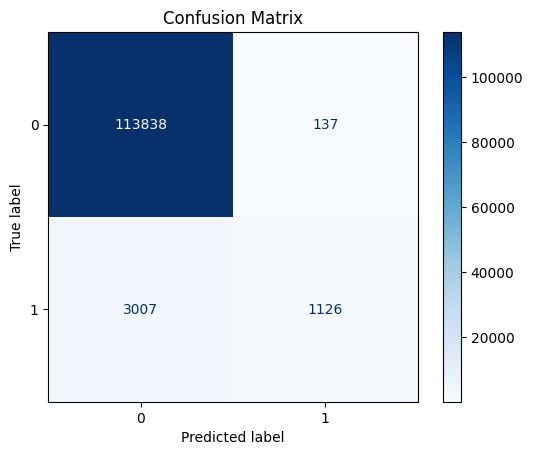

In [31]:
# Predictions on training data
y_pred = final_rf.predict(X_train_pca)
y_pred_proba = final_rf.predict_proba(X_train_pca)[:, 1]

# Evaluate model
accuracy = accuracy_score(y_train_final, y_pred)  # Use y_train_final, not y_train
precision = precision_score(y_train_final, y_pred)
recall = recall_score(y_train_final, y_pred)
roc_auc = roc_auc_score(y_train_final, y_pred_proba)
conf_matrix = confusion_matrix(y_train_final, y_pred)

# Print Metrics
print("\nFinal Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Now, you can also evaluate on the validation set if needed
y_val_pred = final_rf.predict(X_val_pca)
y_val_pred_proba = final_rf.predict_proba(X_val_pca)[:, 1]

# Evaluate model on validation data
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred_proba)
val_conf_matrix = confusion_matrix(y_val, y_val_pred)

# Print validation metrics
print("\nFinal Model Performance on Validation Data:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"ROC AUC Score: {val_roc_auc:.4f}")
print("\nConfusion Matrix:")
print(val_conf_matrix)

# Print Classification Report
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_rf.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()